# DS 102 Bootcamp 15/08/2020 Week 1 Part 2

## Instructor: Engin Deniz Alpman

# Random Forest Model interpretation

**In this lesson we will try to find out what are important in predicting the output**

In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [85]:
import pandas as pd
import numpy as np

In [86]:
import math

In [87]:
import re
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

* If there are columns that have nan values in validation or test set but not in train set, previous proc_df function will cause error, so we should modify the proc_df

In [91]:
def numericalize(df, col, name):
    if not is_numeric_dtype(col):
        df[name] = col.cat.codes+1

In [92]:
def fix_missing(df, col, name, nan_dict, is_train):
    
    if is_train:
        if is_numeric_dtype(col):
            if pd.isnull(col).sum():
                df[name+"_na"] = pd.isnull(col)
                nan_dict[name] = col.median()
                df[name] = col.fillna(nan_dict[name])
            
            
    else:
        if is_numeric_dtype(col):
            if name in nan_dict:
                df[name+"_na"] = pd.isnull(col)
                df[name] = col.fillna(nan_dict[name])
                
        
            else:
                print(f"{name} has missing value(s) in the test set but not in the training set, additional care is needed")
            
            
            

In [93]:
def proc_df(df, y_fld,nan_dict=None,is_train=True):
    
    df = df.copy()
    y = df[y_fld].values
    
    df.drop(y_fld, axis = 1, inplace = True)
    
    if nan_dict is None:
        nan_dict = {}
    
    for n, c in df.items():
        fix_missing(df, c, n,nan_dict, is_train)
        numericalize(df, c, n)
        
        
    
    return df, y, nan_dict

## Load in our data from last lesson

In [94]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers_1')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [95]:
len(df_raw.columns)

65

In [96]:
# split our training data to validation and train set
def split_vals(a,n): 
    return a[:n], a[n:]

n_valid = 12000
n_trn = len(df_trn)-n_valid
x, x_valid = split_vals(df_trn, n_trn)
y, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [97]:
def rmse(x,y): # y_actual - y_predict 
    return math.sqrt(((x-y)**2).mean())


def print_score(m):
    
    print(f"RMSLE of train set {rmse(m.predict(x), y)}")
    print(f"RMSLE of validation set {rmse(m.predict(x_valid), y_valid)}")
    print(f"R^2 of train set {m.score(x, y)}")
    print(f"R^2 of validation set {m.score(x_valid, y_valid)}")

In [98]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,NaN,30NX,...,25,1,298,False,False,False,False,False,False,1319500800


# Confidence based on tree variance

To interpret a model we don't need a full data, so we will again use subsampling

In [99]:
from sklearn.ensemble import forest

In [100]:
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

In [101]:
def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

* If you are obtaining similar results when you run the model again and again, that number is **generally** sufficient for testing out new ideas etc

In [102]:
set_rf_samples(50000)

In [103]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(x, y)
print_score(m)

Wall time: 9.6 s
RMSLE of train set 0.20558124227472724
RMSLE of validation set 0.2480717622842703
R^2 of train set 0.9116713082237193
R^2 of validation set 0.8900987485697287


* Our model is averages the predictions of different trees. There is an important point, how confident we are on this estimate ? 

* If some rows are less common than others, they will probably end up in different nodes in different trees, because trees will be created to catch the general trend. So we can say that we will be less confident about our prediction if we didn't see rows like the one that we are trying to predict.

* Trees will not be created acording to those rare rows, so there will most probably not a specific paths created for those rows so that is why they will likely to be end up different places in different trees

**If we calculate the standard deviation of predictions of different trees and if std is high, we can say that different trees are giving very different results for those specific rows/inputs**

**If the rows are common rows, so trees would learn make good predictions using them, so we can expect std to be low in this case**

**So Std of predictions across trees is related to how confident we are**

**If std is high, we may want to be more suspicious of those results**

* We will create something similar to the previous lectures stacked means

In [104]:
%time preds = np.array([t.predict(x_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 1.18 s


(9.211202743276957, 0.1628774573974694)

* First number is to prection for row 1, and second number is a standard deviation of that prediction

In order to see how prediction confidence varies, we can add this into our dataset.

In [106]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0) # std of our predictions
x['pred'] = np.mean(preds, axis=0) # our predictions

In [107]:
# Some of them are 0, they present in this list because we created categories according to df_raw
x["Enclosure"].value_counts() # It was an important feature in our model

OROPS                  4913
EROPS w AC             3777
EROPS                  3308
None or Unspecified       0
NO ROPS                   0
EROPS AC                  0
Name: Enclosure, dtype: int64

In [108]:
df_raw["Enclosure"].value_counts()

OROPS                  173932
EROPS                  139026
EROPS w AC              87820
EROPS AC                   17
NO ROPS                     3
None or Unspecified         2
Name: Enclosure, dtype: int64

**It does not matter if we know what Enclosure column is ! That is often the case actually. You will come across lots of dataset that you will have no idea. But what we are trying to do now is to understand which ones are important and which ones we have to give more of our attention etc**

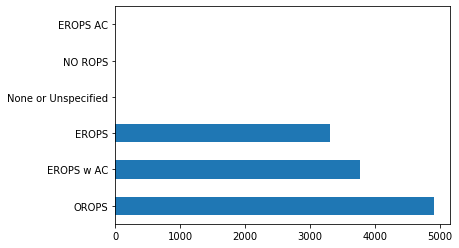

In [109]:
x["Enclosure"].value_counts().plot.barh();

**Difference between as_index=True and False**

* We will take the mean, so it is like: On average, Enclosure-EROPS is predicted 9.83 and on average in that category standard deviation of predictions is 0.27

In [110]:
fields = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enclosure_table = x[fields].groupby('Enclosure', as_index=True).mean() 
enclosure_table

,SalePrice,pred,pred_std
Enclosure,,,
EROPS,9.849178,9.838998,0.266374
EROPS AC,NaN,NaN,NaN
EROPS w AC,10.623971,10.579604,0.263633
NO ROPS,NaN,NaN,NaN
None or Unspecified,NaN,NaN,NaN
OROPS,9.682064,9.682318,0.221887


In [111]:
fields = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enclosure_table = x[fields].groupby('Enclosure', as_index=False).mean()
enclosure_table

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.838998,0.266374
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.579604,0.263633
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.682318,0.221887


**EROPS	9.849178	9.835921	0.277164**

* The above one is like, avr price of Enclosure=EROPS is 9.84, avr prediction across the trees for that is 9.83 and std of the predictions is 0.27

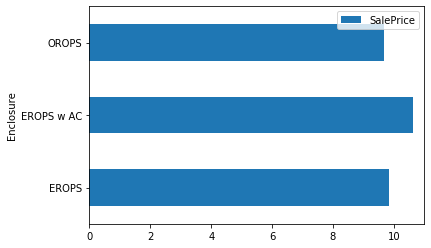

In [112]:
enclosure_table= enclosure_table[~pd.isnull(enclosure_table["SalePrice"])] # take only present ones in our sample
enclosure_table.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

we are using error bars as std indicator (avr of std of that particular case)

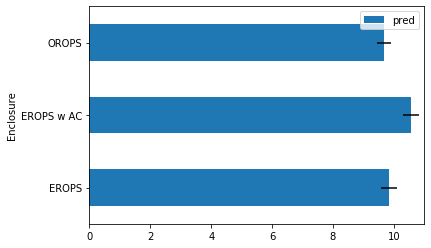

In [113]:
enclosure_table.plot('Enclosure', 'pred', 'barh', xerr='pred_std', xlim=(0,11));

* We can do the same thing to productsize feature

In [115]:
raw_valid["ProductSize"].value_counts()

Large / Medium    1706
Medium            1549
Mini              1369
Small              624
Large              297
Compact            143
Name: ProductSize, dtype: int64

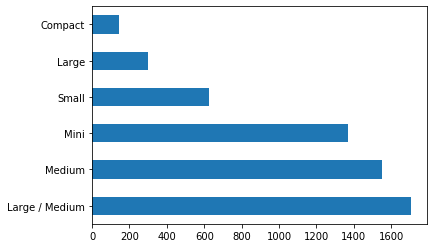

In [116]:
raw_valid["ProductSize"].value_counts().plot.barh();

In [117]:
fields = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
size_table = x[fields].groupby('ProductSize').mean()

In [119]:
size_table

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.855657,0.329148
Large,10.470589,10.372283,0.376508
Large / Medium,10.691871,10.657220,0.288942
Medium,10.681511,10.618058,0.285550
Mini,9.535147,9.556341,0.239998
Small,10.324448,10.325662,0.300752


* As we talked our previous lectures, important one is not **how big the number is, scale is important !** If we are predicting big numbers we may expect to have bigger std

In [120]:
(size_table["pred_std"]/size_table["pred"]).sort_values(ascending=False)

ProductSize
Large             0.036299
Compact           0.033397
Small             0.029127
Large / Medium    0.027112
Medium            0.026893
Mini              0.025114
dtype: float64

**So we can say that we are less confident in the prediction of the prices of productsize = large or compact !!**

**That is no surprise ! Those are the rare ones !**

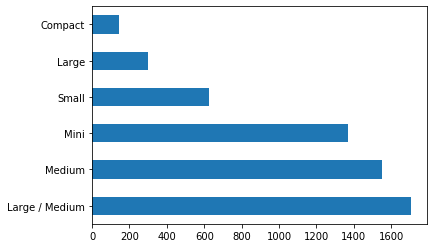

In [121]:
raw_valid["ProductSize"].value_counts().plot.barh();

* So you can use this std approach to group our data as we did and look at how confident we are at each group etc

* Or you can look at **specific input/row** and calculate the std across our trees to see our confidence

# Feature importance

We may also want how our model is making predictions, and we can investigate this by **feature importance**

**In practice you can build random forest as fast as you can, and that model does not have to be perfect but it has to learn some patterns, then plot feature importance to learn more about data !**

This function is  wrapper around sklearn model objects.

* It will create a df that shows feature importance

In [122]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'columns':df.columns, 'importance':m.feature_importances_}
                       ).sort_values('importance', ascending=False)

In [123]:
len(m.feature_importances_) # equals to the number of columns

66

In [124]:
m.feature_importances_

array([2.69212176e-02, 1.59693645e-02, 5.79861978e-02, 8.33074073e-04,
       3.78819707e-03, 1.79673639e-01, 2.22542410e-03, 9.35826109e-04,
       3.27891392e-02, 2.18563315e-02, 3.58808512e-02, 4.27546851e-03,
       1.86645303e-02, 1.05251956e-01, 7.82051028e-02, 6.41358011e-03,
       1.43526474e-02, 9.37002821e-03, 7.62131239e-03, 2.92345893e-02,
       6.81816399e-04, 1.98963538e-03, 5.74298170e-04, 2.38066819e-03,
       1.28794777e-03, 7.57170325e-04, 8.62895288e-05, 2.45579986e-03,
       9.67655832e-04, 1.31833798e-03, 8.94461090e-03, 6.05779031e-04,
       3.00294264e-03, 1.02722211e-03, 1.78365795e-04, 7.35295026e-03,
       2.58748831e-03, 1.21940354e-01, 2.40261062e-02, 5.14615872e-02,
       5.79955649e-03, 1.05338853e-03, 3.67718031e-03, 7.76962895e-04,
       2.66082319e-04, 6.70065575e-04, 2.19535932e-04, 3.14089311e-03,
       1.47705947e-03, 1.56004805e-04, 1.79241792e-04, 2.07303336e-02,
       2.45463595e-03, 4.70125660e-03, 6.46575728e-03, 3.19746666e-03,
      

In [125]:
feature_importance = rf_feat_importance(m, df_trn);

In [126]:
feature_importance[:10]

,columns,importance
5,YearMade,0.179674
37,Coupler_System,0.121940
13,ProductSize,0.105252
14,fiProductClassDesc,0.078205
2,ModelID,0.057986
63,saleElapsed,0.051541
39,Hydraulics_Flow,0.051462
10,fiSecondaryDesc,0.035881
8,fiModelDesc,0.032789
19,Enclosure,0.029235


* You can see that some columns are very important at prediction and some columns are not important 

**Why is that important?**

**You can start to learn what most important columns mean, and by doing that way you can give your attention most important ones!**

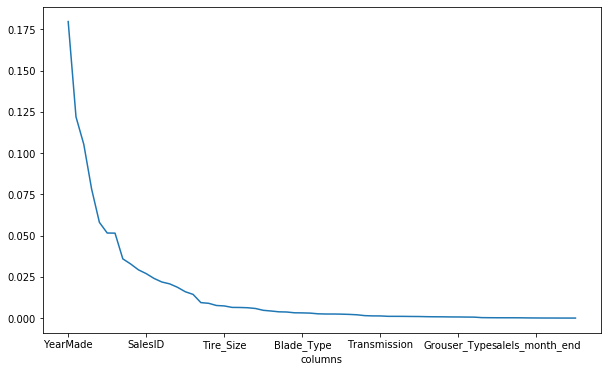

In [127]:
feature_importance.plot('columns', 'importance', figsize=(10,6), legend=False);

In [128]:
def plot_feature_importance(fi): 
    return fi.plot('columns', 'importance', 'barh', figsize=(12,7), legend=False)

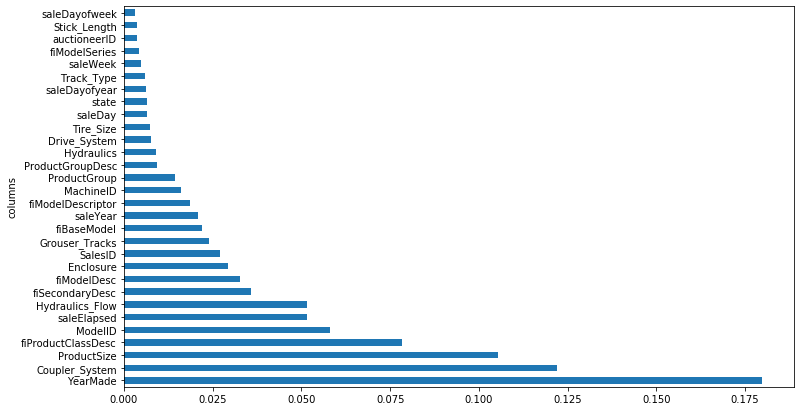

In [129]:
plot_feature_importance(feature_importance[:30]);

**Do learn about what the most important ones really mean**

**Throw least important ones and see if there is too much change or not**

In [130]:
# Select the most important ones
keep_columns = feature_importance[feature_importance["importance"]>0.005]["columns"]; 
len(keep_columns)

25

In [133]:
df_keep = df_trn[keep_columns].copy()
x, x_valid = split_vals(df_keep, n_trn)

In [134]:
y, y_valid = split_vals(y_trn, n_trn)

In [135]:
y

array([11.09741002, 10.95080655,  9.21034037, ..., 10.46310334,
        9.21034037,  9.10497986])

In [136]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(x, y)
print_score(m)

RMSLE of train set 0.2071450375480543
RMSLE of validation set 0.24628140362019552
R^2 of train set 0.9103224172606605
R^2 of validation set 0.8916793607927209


**It did not mattered !**

**Sometimes getting rid of redundant data increases your accuracy because it reduce the risk of your model to find false patterns**

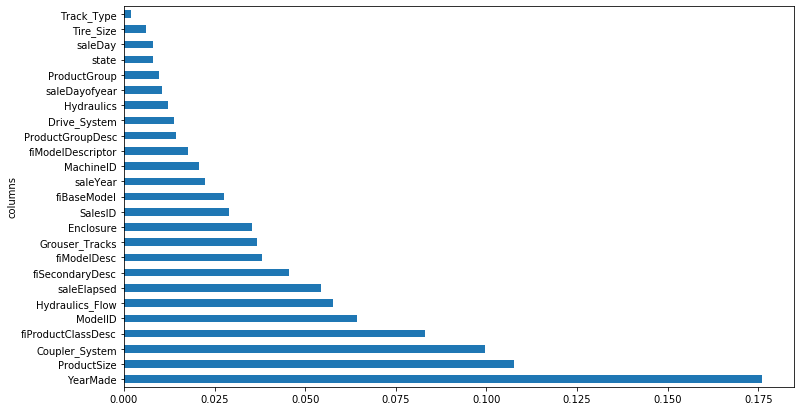

In [137]:
feature_importance = rf_feat_importance(m, df_keep)
plot_feature_importance(feature_importance);

**By removing redundant columns you can eliminate some colinearity and that makes your plot more clear, because colinearity divide importance by colinear ones!**

* It increased the importance of yearmade, and that makes sense that yearmade can be correlated with lots of variables (like some kind of variables can be accessible after some year etc)

**Explain how feature importance works !**

## One-hot encoding


For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

* Maybe some specific feature is important, so to be able to have split for that may require more than 1 split, but we can do that with one hot encodings, and that can make our splits optimal because splits are made greedy, so **we may not reach that split because maybe required splits were not optimal** . It is also bad for computational point of view but that is not the only reason as we saw

In [139]:
def numericalize(df, col, name, max_cat):
    if not is_numeric_dtype(col) and (max_cat is None or len(col.cat.categories)>max_cat):
        df[name] = pd.Categorical(col).codes+1

In [140]:
def fix_missing(df, col, name, nan_dict, is_train):
    
    if is_train:
        if is_numeric_dtype(col):
            if pd.isnull(col).sum():
                df[name+"_na"] = pd.isnull(col)
                nan_dict[name] = col.median()
                df[name] = col.fillna(nan_dict[name])
            
            
    else:
        if is_numeric_dtype(col):
            if name in nan_dict:
                df[name+"_na"] = pd.isnull(col)
                df[name] = col.fillna(nan_dict[name])
                
        
            else:
                df[name] = col.fillna(col.median())
            
            
            

**When cardinality is very high it does not apply one hot encoding**

In [141]:
def proc_df(df, y_fld,nan_dict=None,is_train=True, max_cat=None):
    
    df = df.copy()
    y = df[y_fld].values
    
    df.drop(y_fld, axis = 1, inplace = True)
    
    if nan_dict is None:
        nan_dict = {}
    
    for n, c in df.items():
        fix_missing(df, c, n,nan_dict, is_train)
        numericalize(df, c, n, max_cat)
        
    df = pd.get_dummies(df, dummy_na=True)
        
    
    return df, y, nan_dict


In [142]:
df_train2, y_train, nan_dict = proc_df(df_raw, 'SalePrice', max_cat=7)

x, x_valid = split_vals(df_train2, n_trn)
y, y_valid = split_vals(y_train, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(x, y)
print_score(m)

RMSLE of train set 0.20746658602967297
RMSLE of validation set 0.2554097902072488
R^2 of train set 0.9100437905406024
R^2 of validation set 0.8835007700597824


In [143]:
df_train2, y_train, nan_dict = proc_df(df_raw, 'SalePrice', max_cat=7)

In [144]:
x, x_valid = split_vals(df_train2, n_trn)
y, y_valid = split_vals(y_train, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(x, y)
print_score(m)

RMSLE of train set 0.2072144556545765
RMSLE of validation set 0.2534282685695743
R^2 of train set 0.9102623019794797
R^2 of validation set 0.8853014079315662


**It made our model less predictive but maybe it can tell us new things about feature importance!**

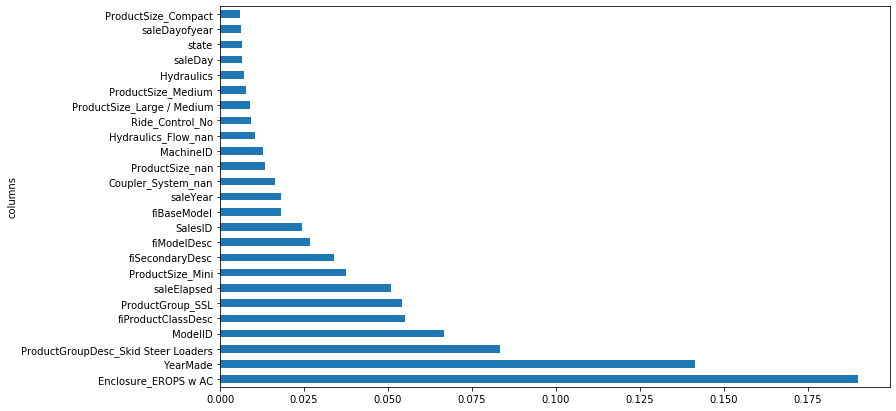

In [145]:
feature_importance = rf_feat_importance(m, df_train2)
plot_feature_importance(feature_importance[:25]);

**So you should check for EROPS w AC**

# Removing redundant features

**Dendrogram**: Hierarchical Clustering

We will use clustering to find which ones are similar

If some variable have similar meanings it is harder to interpret feature importance, and it can increase the risk of false pattern recognition , so we will try to remove those and check if accuracy is decreasing

In [146]:
import scipy

In [147]:
from scipy.cluster import hierarchy as hc

In [148]:
from matplotlib import pyplot as plt

* Explain the differences between pearson and spearman correlation

* Spearman replace everything with their rank so that it can capture non-linear relations too!

* In new plot you don't plot the data you plot the rank of the data

In [152]:
np.round(1.2344,2)

1.23

In [153]:
np.round(1.2344,3)

1.234

In [154]:
scipy.stats.spearmanr(df_keep).correlation

array([[ 1.00000000e+00,  1.86735714e-01, -2.52075282e-02,
        -1.47139483e-01,  9.55397665e-02,  5.12220019e-01,
         1.85094057e-01,  1.31332106e-01, -7.63856138e-02,
         1.33606944e-01,  2.30147562e-01,  1.86962745e-01,
        -8.19417864e-02,  5.12166278e-01,  2.21905974e-01,
        -3.80809534e-02, -1.31049596e-01, -1.31049596e-01,
         2.92095494e-02, -4.22192569e-02, -1.89029930e-01,
         1.80190298e-02, -4.61612123e-02,  1.53609195e-02,
         8.91074168e-02],
       [ 1.86735714e-01,  1.00000000e+00, -3.10879233e-01,
         8.21984914e-02,  2.49480318e-01,  8.10666317e-02,
         9.98209396e-01, -2.82603825e-01, -2.14921985e-02,
         3.14195713e-01,  8.53554531e-02,  9.98096834e-01,
        -2.16920040e-02,  8.03648775e-02, -1.60546486e-01,
         3.92692938e-02, -2.26873725e-01, -2.26873725e-01,
         3.56303329e-01, -2.03935469e-01, -1.91686819e-01,
         4.13369773e-03, -1.37075213e-02,  1.53561849e-02,
        -1.98663808e-01],
    

In [155]:
??hc

* Where they meet is the indicator of similarity in this plot

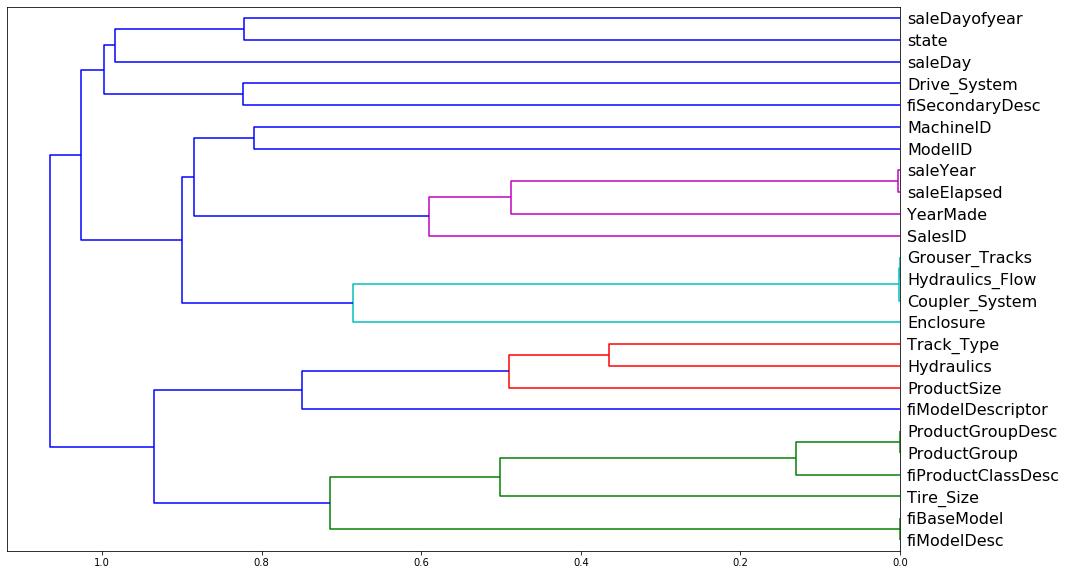

In [156]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

* We will try to remove similar features and see if it affects our accuracy

In [157]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y)
    return m.oob_score_

Here's our baseline.

In [158]:
get_oob(df_keep)

0.8906339199471747

**Loop through things that you think that maybe redundant**

In [85]:
for col_name in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(col_name, get_oob(df_keep.drop(col_name, axis=1)))

saleYear 0.8877178855197787
saleElapsed 0.8850877564017605
fiModelDesc 0.8864356894774773
fiBaseModel 0.8878764763624234
Grouser_Tracks 0.8885260834289503
Coupler_System 0.8880227548117755


Try to drop 1 at each **group**

In [159]:
drop_list = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(drop_list, axis=1))

0.8890956948988866

That is not that much drop, so we will try to move without those column

In [160]:
df_keep.drop(drop_list, axis=1, inplace=True)
x, x_valid = split_vals(df_keep, n_trn)

In [161]:
keep_col_name = np.array(df_keep.columns)

In [162]:
df_keep = df_trn[keep_col_name]

And let's see how this model looks on the full dataset.

In [163]:
x, x_valid = split_vals(df_keep, n_trn)

In [164]:
reset_rf_samples()

In [165]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y)
print_score(m)

RMSLE of train set 0.12505509266695938
RMSLE of validation set 0.22724167670915224
R^2 of train set 0.96731582020897
R^2 of validation set 0.9077802492396794


# Partial dependence

In [166]:
from pdpbox import pdp
from plotnine import *

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [167]:
set_rf_samples(50000)

In [168]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_cat=7)
x, x_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(x, y);

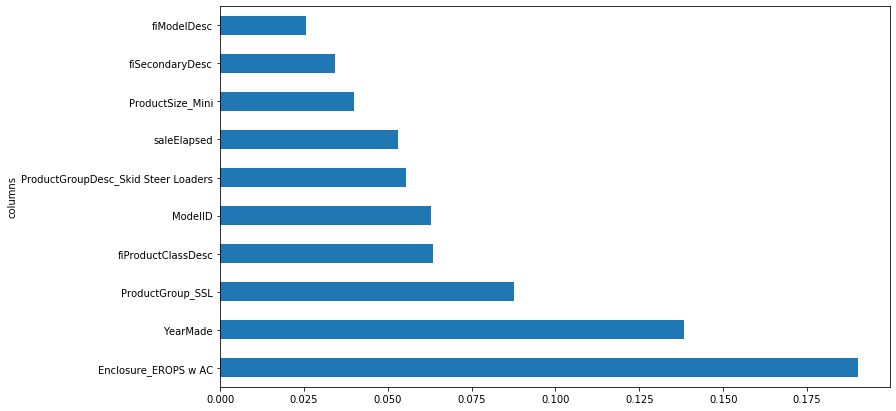

In [169]:
plot_feature_importance(rf_feat_importance(m, df_trn2)[:10]);

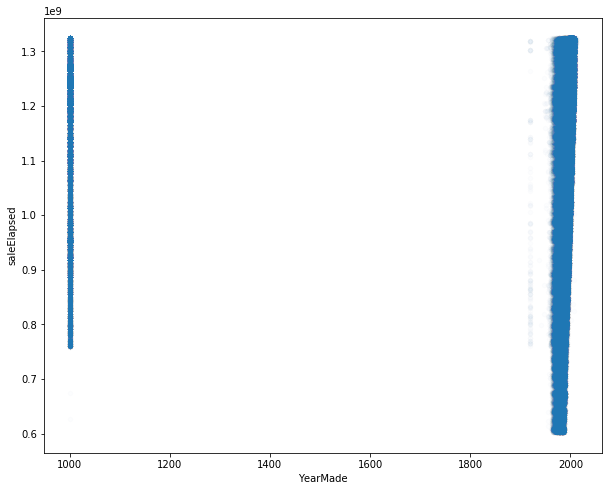

In [170]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [171]:
def get_sample(df,n):
    
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [172]:
df_raw[df_raw.YearMade>1930].shape

(362796, 65)

In [173]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 60000)

In [174]:
?? stat_smooth

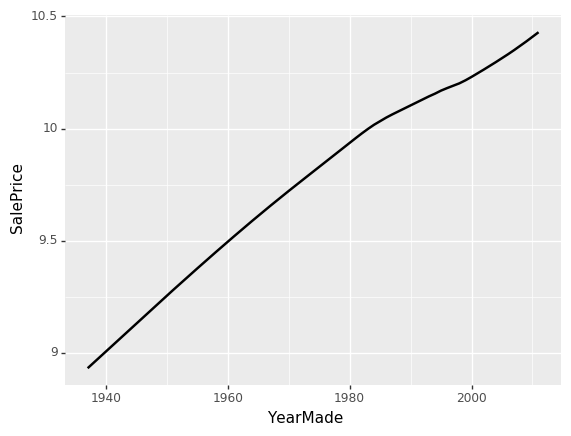

<ggplot: (-9223371870815399612)>

In [175]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='lowess' )

In [176]:
x_sample = get_sample(x[x["YearMade"]>1930], 1000)

In [177]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x_sample, x_sample.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

In [178]:
x.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'fiModelDesc', 'fiBaseModel',
       'fiSecondaryDesc',
       ...
       'Differential_Type_Locking', 'Differential_Type_No Spin',
       'Differential_Type_Standard', 'Differential_Type_nan',
       'Steering_Controls_Command Control', 'Steering_Controls_Conventional',
       'Steering_Controls_Four Wheel Standard', 'Steering_Controls_No',
       'Steering_Controls_Wheel', 'Steering_Controls_nan'],
      dtype='object', length=173)

Each blue lines are different rows

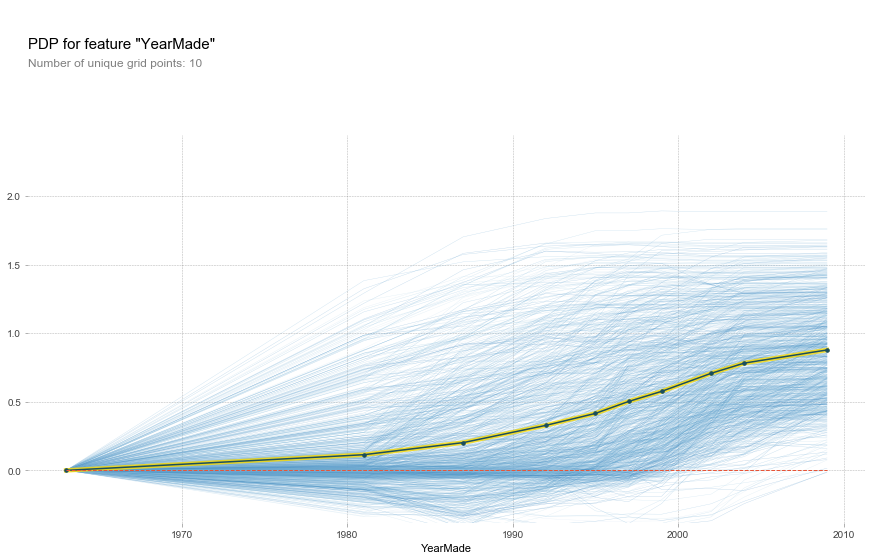

In [179]:
plot_pdp('YearMade');

**Linear behaviour in the interval that we have reasonable amount of data is because we expect to, all other things being equal, newer ones to be more expensive because of inflation and because of they are newer**

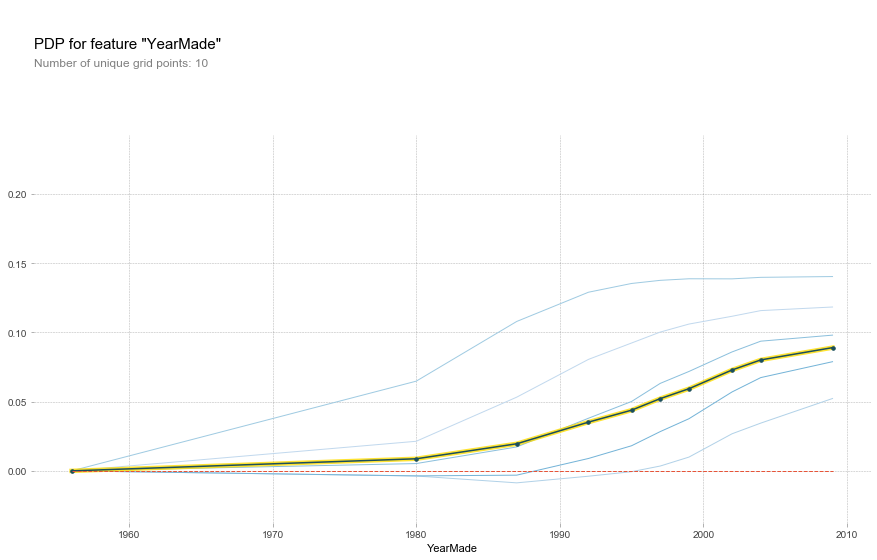

In [107]:
plot_pdp('YearMade', clusters=5);

**Different kind of vehicles behaves diffently with YearMade**

## How Multiple Variable Impacts Dependent Variable

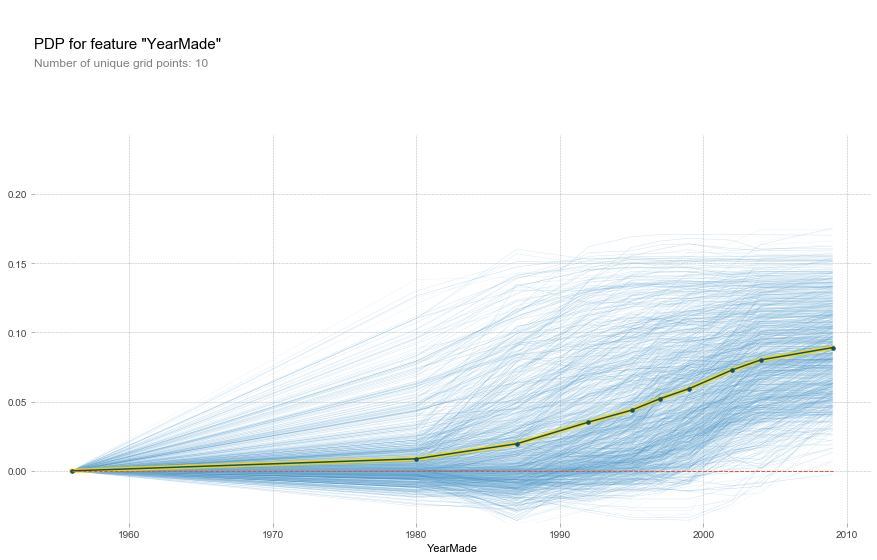

In [108]:
plot_pdp('YearMade');

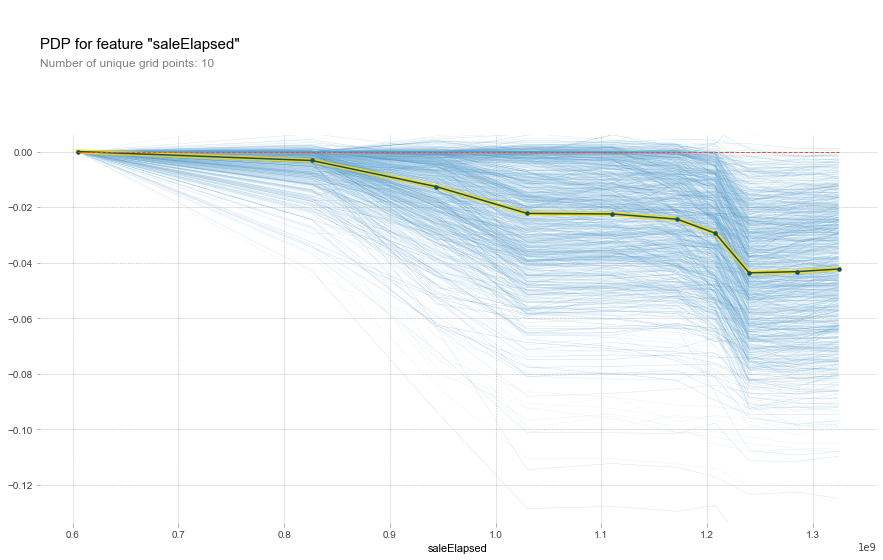

In [109]:
plot_pdp('saleElapsed');

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2a385af2308>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2a385a9c788>})

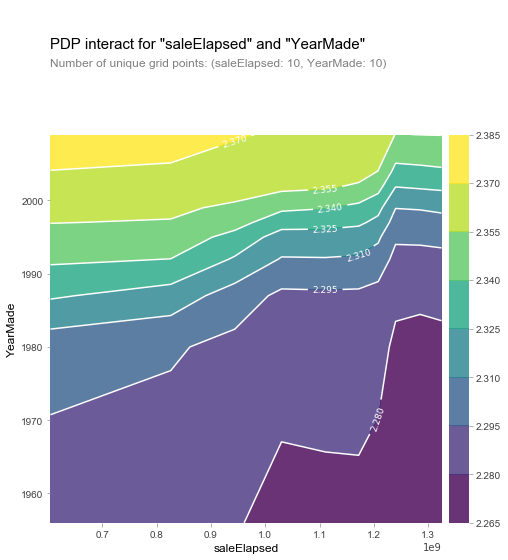

In [110]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x_sample, x_sample.columns, feats)
pdp.pdp_interact_plot(p, feats)

**saleElapsed gives us how much time passed before vehicle is sold, so we expect its relation with saleprice to be negative one**

## Partial Dependence of Categorical Variables

* ['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS']  names of the features we want to plot

* 5 is cluster number

* the last parameter is the name that appears

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2a38236d188>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2a3822b6648>})

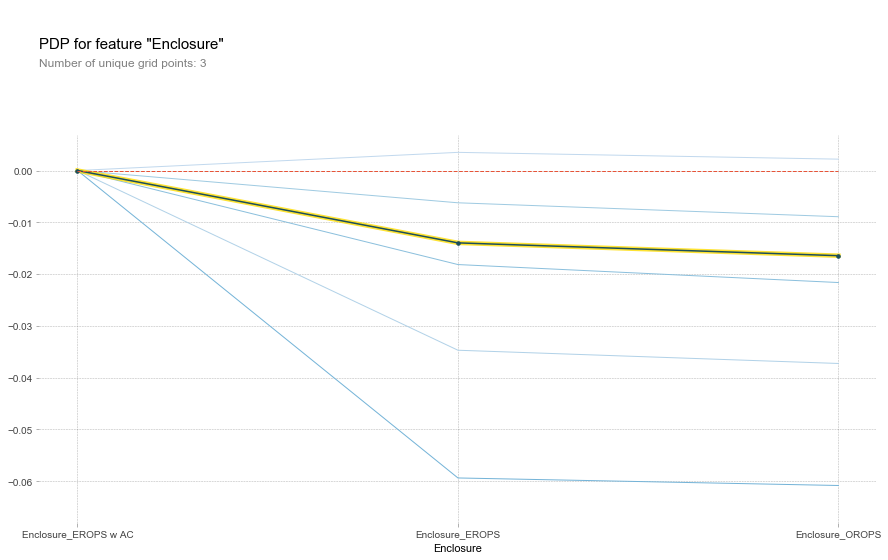

In [111]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [112]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

In [113]:
x, x_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(x, y)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

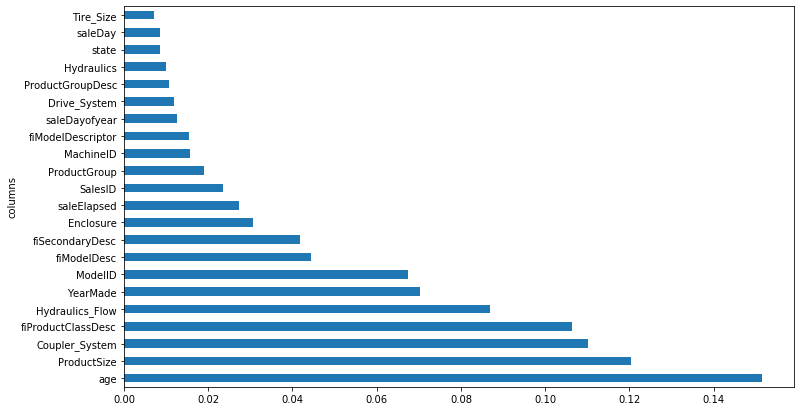

In [114]:
plot_feature_importance(rf_feat_importance(m, df_keep));

That does not mean model will be better with age column, because previous model can capture that pattern with multiple splitting too

# Tree interpreter

This is really important for real life, but maybe not so much for competitions

* It answers the question why did we make that prediction?

In [115]:
from treeinterpreter import treeinterpreter as ti

In [116]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [117]:
x_valid.values

array([[1999,    0,    5, ...,    0,    4,   11],
       [1996,    0,    5, ...,    0,    4,   14],
       [1993,    0,    5, ...,    0,    4,   17],
       ...,
       [2005,    0,    5, ...,    0,    4,    6],
       [2005,    0,    5, ...,    0,    4,    6],
       [2005,    0,    5, ...,    0,    4,    6]], dtype=int64)

In [118]:
x_valid.values.shape

(12000, 22)

In [119]:
# row 0
row = x_valid.values[None,0]; row

array([[      1999,          0,          5,         17,          0,
               665, 1284595200,          1,          0,       3232,
           4364751,    2300944,          0,          4,         12,
                 0,         16,         35,        259,          0,
                 4,         11]], dtype=int64)

In [120]:
prediction, bias, contributions = ti.predict(m, row)

In [146]:
# second one is the avr sale price across the dataset (base model,first node's prediction)
prediction[0], bias[0]

(array([2.22675889]), 2.3108287376088015)

* Explain contribution

In [147]:
contributions.shape

(1, 22)

In [123]:
idxs = np.argsort(contributions[0])

* Marginal differences

* It will give the affects of features of the row to prediction

In [124]:
idxs

array([ 2, 21,  3,  9,  8, 19, 18, 10, 12, 17,  7, 16,  6, 11, 20, 14, 15,
       13,  4,  1,  5,  0], dtype=int64)

In [125]:
df_keep.shape

(401125, 22)

In [126]:
df_valid.shape

(12000, 22)

In [127]:
idxs.shape

(22,)

In [128]:
[o for o in zip(x_valid.columns[idxs], x_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 5, -0.057077518723454714),
 ('age', 11, -0.014206219321626879),
 ('fiProductClassDesc', 17, -0.013606747605984626),
 ('fiModelDesc', 3232, -0.008869337058385917),
 ('fiSecondaryDesc', 0, -0.007924341288863934),
 ('Tire_Size', 0, -0.002492834742905392),
 ('saleDayofyear', 259, -0.001977041546982761),
 ('SalesID', 4364751, -0.0017262631421384067),
 ('fiModelDescriptor', 0, -0.0017161328518441542),
 ('state', 35, -0.001150981616669633),
 ('Enclosure', 1, -0.0007420203762871225),
 ('saleDay', 16, 0.0001867333169169205),
 ('saleElapsed', 1284595200, 0.00026944840907783263),
 ('MachineID', 2300944, 0.00029716573450173646),
 ('ProductGroupDesc', 4, 0.0003089130937020901),
 ('Hydraulics', 12, 0.0005950098322195063),
 ('Drive_System', 0, 0.0008043327786502408),
 ('ProductGroup', 4, 0.0010991425058932136),
 ('Hydraulics_Flow', 0, 0.0037402084484317254),
 ('Coupler_System', 0, 0.005370075756088144),
 ('ModelID', 665, 0.005494374791047385),
 ('YearMade', 1999, 0.009254185745033117

In [129]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.057077518723454714),
 ('age', 11, -0.014206219321626879),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.013606747605984626),
 ('fiModelDesc', 'KX1212', -0.008869337058385917),
 ('fiSecondaryDesc', nan, -0.007924341288863934),
 ('Tire_Size', nan, -0.002492834742905392),
 ('saleDayofyear', 259, -0.001977041546982761),
 ('SalesID', 4364751, -0.0017262631421384067),
 ('fiModelDescriptor', nan, -0.0017161328518441542),
 ('state', 'Ohio', -0.001150981616669633),
 ('Enclosure', 'EROPS', -0.0007420203762871225),
 ('saleDay', 16, 0.0001867333169169205),
 ('saleElapsed', 1284595200, 0.00026944840907783263),
 ('MachineID', 2300944, 0.00029716573450173646),
 ('ProductGroupDesc', 'Track Excavators', 0.0003089130937020901),
 ('Hydraulics', 'Standard', 0.0005950098322195063),
 ('Drive_System', nan, 0.0008043327786502408),
 ('ProductGroup', 'TEX', 0.0010991425058932136),
 ('Hydraulics_Flow', nan, 0.0037402084484317254),
 ('Coupler_Sys

In [130]:
contributions[0].sum()

-0.08406984786358163

In [131]:
a = np.array([1,2,3,4])
a

array([1, 2, 3, 4])

In [132]:
b = a[None,:]
b

array([[1, 2, 3, 4]])

In [133]:
a.shape

(4,)

In [134]:
b.shape

(1, 4)

# Dealing with Extrapolation

We are adding new column to say us if that is comming from validation set or not

In [148]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

This random forest is predicting if the data is coming from validation set or not

In [149]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999850420691805

If we find the feature importance of this model, this will tell us the important parameters that differentiate validation from training

* SalesID is important in determining in validation set so it cannot be random, it is related to time

Don't just look order, look at their values too. Top 3-4 is more important than the rest

In [150]:
fi = rf_feat_importance(m, x); fi[:10]

,columns,importance
10,SalesID,0.811312
6,saleElapsed,0.133190
11,MachineID,0.046430
5,ModelID,0.002346
9,fiModelDesc,0.001770
0,YearMade,0.001654
18,saleDayofyear,0.001110
14,Hydraulics,0.000650
1,Coupler_System,0.000400
8,fiSecondaryDesc,0.000354


In [151]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [152]:
(x[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,401125.000000,4.011250e+05,401125.000000
mean,1919.712522,1.091433e+06,1217.902518
std,909.021493,1.816977e+05,440.991954
min,1139.246000,6.009984e+05,0.000000
25%,1418.371000,9.708768e+05,1088.697000
50%,1639.422000,1.143072e+06,1279.490000
75%,2242.707000,1.237853e+06,1468.067000
max,6333.342000,1.325203e+06,2486.330000


In [153]:
(x_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [154]:
x.drop(feats, axis=1, inplace=True)

In [155]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9790190090370832

In [124]:
fi = rf_feat_importance(m, x); fi[:10]

,columns,importance
18,age,0.232021
0,YearMade,0.196466
16,saleDayofyear,0.148607
4,ModelID,0.079565
8,fiModelDesc,0.061572
14,saleDay,0.061142
15,state,0.057843
3,fiProductClassDesc,0.032400
6,fiSecondaryDesc,0.023306
7,Enclosure,0.020466


In [125]:
set_rf_samples(50000)

**Trick:**

**Put competition's test data to your training set and create column called "is_test", build a model that predicts that column. If your model can predict in a reasonable range, that means test set is not RANDOM !! So cross validation and built-in splitting methods will not representative of testset, so you have to figure out how to create validation set!!**

In [156]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [157]:
y, y_valid = split_vals(y_trn, n_trn)

In [158]:
x, x_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y)
print_score(m)

RMSLE of train set 0.020747550726469523
RMSLE of validation set 0.024944337107358997
R^2 of train set 0.9079856400069114
R^2 of validation set 0.887201138084155


**If taking them is not harmful that is better because that way we will have a model that generalizes over time(or whatever is making validation different) better**

In [129]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    x, x_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(x, y)
    print(f)
    print_score(m)

SalesID
RMSLE of train set 0.20912823594226146
RMSLE of validation set 0.2459271412092537
R^2 of train set 0.9085970580905325
R^2 of validation set 0.8919907633657935
saleElapsed
RMSLE of train set 0.214677549137967
RMSLE of validation set 0.2553000036267119
R^2 of train set 0.9036818609285645
R^2 of validation set 0.8836009017204444
MachineID
RMSLE of train set 0.20687952152190106
RMSLE of validation set 0.24560393078126116
R^2 of train set 0.9105521652233822
R^2 of validation set 0.8922744796838498
age
RMSLE of train set 0.20875380873666555
RMSLE of validation set 0.24723569219187852
R^2 of train set 0.9089240642505638
R^2 of validation set 0.8908382951386357
YearMade
RMSLE of train set 0.2092394062309382
RMSLE of validation set 0.25188743476087916
R^2 of train set 0.9084998546477929
R^2 of validation set 0.8866918937625929
saleDayofyear
RMSLE of train set 0.20869425574049205
RMSLE of validation set 0.24513534451441915
R^2 of train set 0.9089760208709727
R^2 of validation set 0.89268

In [130]:
reset_rf_samples()

In [131]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
x, x_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y)
print_score(m)

RMSLE of train set 0.13881715703138736
RMSLE of validation set 0.2170813592555359
R^2 of train set 0.9597263382921657
R^2 of validation set 0.9158424587769479


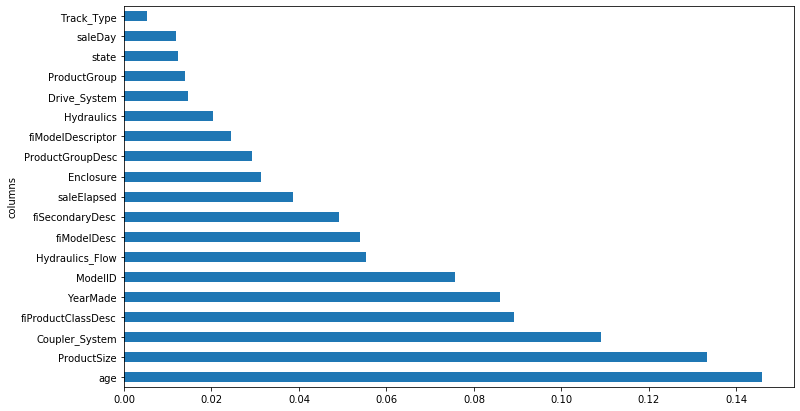

In [132]:
plot_feature_importance(rf_feat_importance(m, x));

In [133]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

In [134]:
# final model
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(x, y)
print_score(m)

Wall time: 38.6 s
RMSLE of train set 0.08036186102919292
RMSLE of validation set 0.21151160274421257
R^2 of train set 0.9865030761573175
R^2 of validation set 0.9201055950864918
